<a href="https://colab.research.google.com/github/CILSON/First-Strategy/blob/main/ALGO1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance backtesting


#1. Fetch BTC data with Python

In [ ]:
import pandas as pd
import yfinance as yf

symbol = "BTC-USD"

data = yf.download(
    [symbol],
    start="2023-12-31",
    interval="1h"      # use "1h" if you want intraday
)

# Clean up
data = data.dropna()
data = data.xs(symbol, axis=1, level="Ticker")
data.head()

/tmp/ipython-input-1631088126.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Datetime,,,,,
2023-12-31 00:00:00+00:00,42336.738281,42400.144531,42152.097656,42152.097656,0
2023-12-31 01:00:00+00:00,42185.359375,42413.117188,42185.359375,42339.230469,0
2023-12-31 02:00:00+00:00,42081.964844,42227.468750,41998.253906,42173.308594,62298112
2023-12-31 03:00:00+00:00,42160.777344,42168.312500,42047.656250,42081.792969,0
2023-12-31 04:00:00+00:00,42213.824219,42294.539062,42155.925781,42166.554688,72495104


In [ ]:
# 200-period SMA on Close
data["SMA200"] = data["Close"].rolling(200).mean()

# 50-period SMA on Close
data["SMA50"] = data['Close'].rolling(50).mean()

# Drop initial NaNs from rolling windows
data = data.dropna()

data[["Close", "SMA200", "SMA50"]].head()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16822 entries, 2024-01-08 07:00:00+00:00 to 2025-12-10 12:00:00+00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   16822 non-null  float64
 1   High    16822 non-null  float64
 2   Low     16822 non-null  float64
 3   Open    16822 non-null  float64
 4   Volume  16822 non-null  int64  
 5   SMA200  16822 non-null  float64
 6   SMA50   16822 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.0 MB


In [ ]:
data["signal"] = 0  # default flat

long_cond  = (data["Close"] > data["SMA200"]) & (data['Close']>data["SMA50"])
# short_cond  = (data["Close"] < data["SMA200"]) & (data['Close'] < data["SMA50"])

data.loc[long_cond,  "signal"] = 1
# data.loc[short_cond, "signal"] = -1

data[["Close", "SMA200", "SMA50", "signal"]].tail()

Price,Close,SMA200,SMA50,signal
Datetime,,,,
2025-12-10 08:00:00+00:00,92650.945312,90998.680391,91480.033594,1
2025-12-10 09:00:00+00:00,92936.851562,91031.160391,91507.886719,1
2025-12-10 10:00:00+00:00,92388.031250,91060.184570,91519.037812,1
2025-12-10 11:00:00+00:00,92112.546875,91085.966953,91522.225469,1
2025-12-10 12:00:00+00:00,92081.125000,91111.519414,91520.905781,1


In [ ]:
import numpy as np

data = data.sort_index()  # make sure it's in time order

data["position"] = 0          # 1 = in long trade, 0 = flat
data["entry_price"] = np.nan
data["trade_return"] = 0.0    # PnL % for each closed trade

in_position = False
entry_price = 0.0

for i in range(len(data)):
    close = data["Close"].iloc[i]
    sma50 = data["SMA50"].iloc[i]
    sma200 = data["SMA200"].iloc[i]

    # NO POSITION → look for entry
    if not in_position:
        if (close > sma50) and (close > sma200):
            in_position = True
            entry_price = close
            data.iloc[i, data.columns.get_loc("position")] = 1
            data.iloc[i, data.columns.get_loc("entry_price")] = entry_price

    # IN POSITION → look for exit
    else:
        stop_price = entry_price * 0.99  # 1% stop-loss
        take_profit = entry_price * 1.02  # 2% Take-profit

        # exit if SL or trend break
        if (close <= stop_price) or (close < sma50) or (close>=take_profit):
            pct_return = (close - entry_price) / entry_price
            data.iloc[i, data.columns.get_loc("trade_return")] = pct_return

            in_position = False
            entry_price = 0.0
        else:
            # still in trade, carry position & entry_price forward
            data.iloc[i, data.columns.get_loc("position")] = 1
            data.iloc[i, data.columns.get_loc("entry_price")] = entry_price


In [ ]:
# Keep only rows where a trade was closed
trades = data[data["trade_return"] != 0]

total_trades = len(trades)
wins = trades[trades["trade_return"] > 0]
losses = trades[trades["trade_return"] <= 0]

win_rate = len(wins) / total_trades if total_trades > 0 else 0
avg_return = trades["trade_return"].mean()

# Equity curve assuming 1 unit capital and full allocation per trade
equity_curve = (1 + trades["trade_return"]).cumprod()

max_equity = equity_curve.cummax()
drawdown = (equity_curve - max_equity) / max_equity
max_drawdown = drawdown.min() if len(drawdown) > 0 else 0

print("Total trades:", total_trades)
print("Win rate:    ", round(win_rate * 100, 2), "%")
print("Avg return:  ", round(avg_return * 100, 2), "% per trade")
print("Max DD:      ", round(max_drawdown * 100, 2), "%")


Total trades: 647
Win rate:     31.07 %
Avg return:   0.1 % per trade
Max DD:       -37.77 %


In [ ]:
trades = data[data["trade_return"] != 0]

wins = trades[trades["trade_return"] > 0]
losses = trades[trades["trade_return"] <= 0]

avg_win   = wins["trade_return"].mean()
avg_loss  = losses["trade_return"].mean()
profit_factor = wins["trade_return"].sum() / abs(losses["trade_return"].sum())

print("Total trades:", len(trades))
print("Win rate:    ", round(len(wins) / len(trades) * 100, 2), "%")
print("Avg win:     ", round(avg_win * 100, 2), "%")
print("Avg loss:    ", round(avg_loss * 100, 2), "%")
print("Profit factor:", round(profit_factor, 2))


Total trades: 647
Win rate:     31.07 %
Avg win:      2.07 %
Avg loss:     -0.78 %
Profit factor: 1.19


<Axes: xlabel='Datetime'>

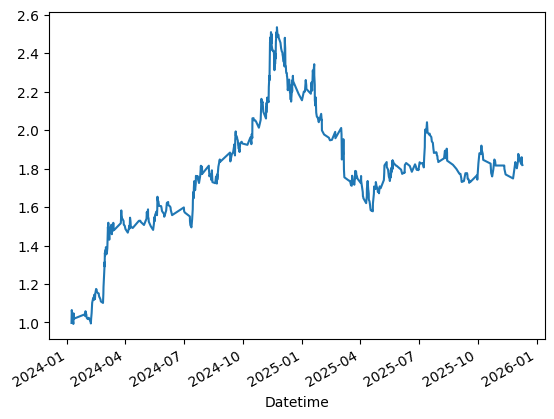

In [ ]:
equity_curve = (1 + trades["trade_return"]).cumprod()
equity_curve.plot()